<a href="https://colab.research.google.com/github/r-kovalch/acter-ner/blob/main/notebooks/acter-heuristics-multilingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git clone https://github.com/r-kovalch/acter-ner

Cloning into 'acter-ner'...
remote: Enumerating objects: 570, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 570 (delta 40), reused 6 (delta 5), pack-reused 491 (from 1)
Receiving objects: 100% (570/570), 7.02 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (366/366), done.


In [5]:
!git clone https://github.com/r-kovalch/extractomat.git && cd extractomat/ && git checkout acter && cd ..
#!git clone https://github.com/lang-uk/extractomat.git

Cloning into 'extractomat'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 52 (delta 25), reused 42 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 54.46 KiB | 899.00 KiB/s, done.
Resolving deltas: 100% (25/25), done.
Branch 'acter' set up to track remote branch 'acter' from 'origin'.
Switched to a new branch 'acter'


In [6]:
!git clone https://github.com/AylaRT/ACTER

Cloning into 'ACTER'...
remote: Enumerating objects: 5448, done.
remote: Counting objects: 100% (5448/5448), done.
remote: Compressing objects: 100% (3304/3304), done.
remote: Total 5448 (delta 2684), reused 4893 (delta 2132), pack-reused 0 (from 0)
Receiving objects: 100% (5448/5448), 11.90 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (2684/2684), done.


In [7]:
!pip install -q \
  numpy==1.26.4 \
  spacy \
  spacy-layout \
  sentence-transformers \
  gitpython \
  matplotlib \
  tqdm -q

!python -m spacy download en_core_web_sm
!python -m spacy download nl_core_news_sm
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.5/185.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), "extractomat"))

import subprocess, sys
from pathlib import Path
from extractomat.matcha import cvalue
import spacy

import numpy as np
import matplotlib.pyplot as plt
from extractomat.tester import TermEvaluator

from extractomat.sbert_reranker import SentenceSimilarityCalculator
import torch

from extractomat.matcha import UPOS_TO_PENN

In [2]:
C_VALUE_MIN_TERMS = 2
C_VALUE_MAX_TERMS = 4
C_VALUE_SMOOTHING = 0.1

In [3]:
root_folder = "content"

language_input_dirs: dict[str, list[str]] = {
    "en": [
        f"/{root_folder}/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ],
    "fr": [
        f"/{root_folder}/ACTER/fr/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ],
    "nl": [
        f"/{root_folder}/ACTER/nl/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ]
}
language_output_dirs: dict[str, dict[str, str]] = {
    "en": {
        "train": f"/{root_folder}/en/train_full.tsv",
        "val":   f"/{root_folder}/en/val_full.tsv",
        "test":  f"/{root_folder}/en/dummy_test.tsv",
    },
    "fr": {
        "train": f"/{root_folder}/fr/train_full.tsv",
        "val":   f"/{root_folder}/fr/val_full.tsv",
        "test":  f"/{root_folder}/fr/dummy_test.tsv",
    },
    "nl": {
        "train": f"/{root_folder}/nl/train_full.tsv",
        "val":   f"/{root_folder}/nl/val_full.tsv",
        "test":  f"/{root_folder}/nl/dummy_test.tsv",
    }
}

languages = list(language_input_dirs.keys())

for language in languages:
    io_dirs = language_input_dirs[language]
    train_tsv = Path(language_output_dirs[language]["train"])
    test_tsv  = Path(language_output_dirs[language]["test"])
    val_tsv   = Path(language_output_dirs[language]["val"])

    language_args = [
        "python",
        f"/{root_folder}/acter-ner/term_extractor/preprocess_acter.py",
        "--input_dirs", *io_dirs,
        "--train_output", str(train_tsv),
        "--test_output",  str(test_tsv),
        "--val_output",   str(val_tsv),
        "--test_size", "0.005",
        "--val_size",  "0.195",
        "--seed",      "42",
    ]
    print("⏳ Running:", language)
    subprocess.check_call(language_args)
    print("✅ Splits ready ", train_tsv, ",", val_tsv, ", and", test_tsv)


⏳ Running: en
✅ Splits ready  /content/en/train_full.tsv , /content/en/val_full.tsv , and /content/en/dummy_test.tsv
⏳ Running: fr
✅ Splits ready  /content/fr/train_full.tsv , /content/fr/val_full.tsv , and /content/fr/dummy_test.tsv
⏳ Running: nl
✅ Splits ready  /content/nl/train_full.tsv , /content/nl/val_full.tsv , and /content/nl/dummy_test.tsv


In [4]:
language_nlp_models: dict[str, str] = {
    "en": "en_core_web_sm",
    "fr": "fr_core_news_sm",
    "nl": "nl_core_news_sm"
}

for lang, model in language_nlp_models.items():
    # load spacy
    nlp = spacy.load(model, disable=["ner","parser"])
    nlp.max_length = 1_500_000

    # read the test-split text
    txt_file = Path(language_output_dirs[lang]["test"]).with_suffix("").joinpath("text.txt")
    doc      = nlp(txt_file.read_text())

    # collect all UPOS tags in the doc
    used_upos = {token.pos_ for token in doc}

    # compute unmapped
    mapped_upos   = set(UPOS_TO_PENN.keys())
    unmapped_upos = used_upos - mapped_upos

    print(f"{lang.upper()}: used UPOS = {sorted(used_upos)}")
    print(f"{lang.upper()}: unmapped = {sorted(unmapped_upos)}\n")

    # assert none are left over
    assert not unmapped_upos, (
        f"❌ Found unmapped UPOS in {lang}: {sorted(unmapped_upos)}"
    )

print("✅ All UPOS tags are covered in EN, FR and NL.")


EN: used UPOS = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB', 'X']
EN: unmapped = []

FR: used UPOS = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'VERB', 'X']
FR: unmapped = []

NL: used UPOS = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB', 'X']
NL: unmapped = []

✅ All UPOS tags are covered in EN, FR and NL.


In [5]:
c_value_results: dict[str, dict] = {
    "en": {
        "train": {},
        "val":   {},
        "test":  {}
    },
    "fr": {
        "train": {},
        "val":   {},
        "test":  {},
    },
    "nl": {
        "train": {},
        "val":   {},
        "test":  {},
    },
}

for language in languages:
    nlp = spacy.load(language_nlp_models[language], disable=["ner"])
    nlp.max_length = 1500000

    for subset in c_value_results[language].keys():
        subset_tsv = Path(language_output_dirs[language][subset])
        doc = nlp(Path(os.path.join(subset_tsv.with_suffix(''), "text.txt")).read_text().lower())

        term_scores, term_occ = cvalue(
            doc,
            n_min=C_VALUE_MIN_TERMS,
            n_max=C_VALUE_MAX_TERMS,
            smoothing=C_VALUE_SMOOTHING,
        )

        c_value_results[language][subset] = {
            "term_scores": term_scores,
            "term_occ":    term_occ
        }

        print(f"Extracted {len(term_scores):,} candidate terms for {subset} for {language}")


Extracted 21,446 candidate terms for train for en
Extracted 6,720 candidate terms for val for en
Extracted 251 candidate terms for test for en
Extracted 8,875 candidate terms for train for fr
Extracted 2,835 candidate terms for val for fr
Extracted 126 candidate terms for test for fr
Extracted 12,148 candidate terms for train for nl
Extracted 3,673 candidate terms for val for nl
Extracted 132 candidate terms for test for nl


In [56]:
records = []

EN train:  P=0.196  R=0.281  F1=0.231
EN val  :  P=0.135  R=0.614  F1=0.221
EN test :  P=0.232  R=0.614  F1=0.337
FR train:  P=0.133  R=0.065  F1=0.087
FR val  :  P=0.156  R=0.095  F1=0.118
FR test :  P=0.096  R=0.225  F1=0.134
NL train:  P=0.181  R=0.096  F1=0.125
NL val  :  P=0.137  R=0.182  F1=0.156
NL test :  P=0.125  R=0.200  F1=0.154


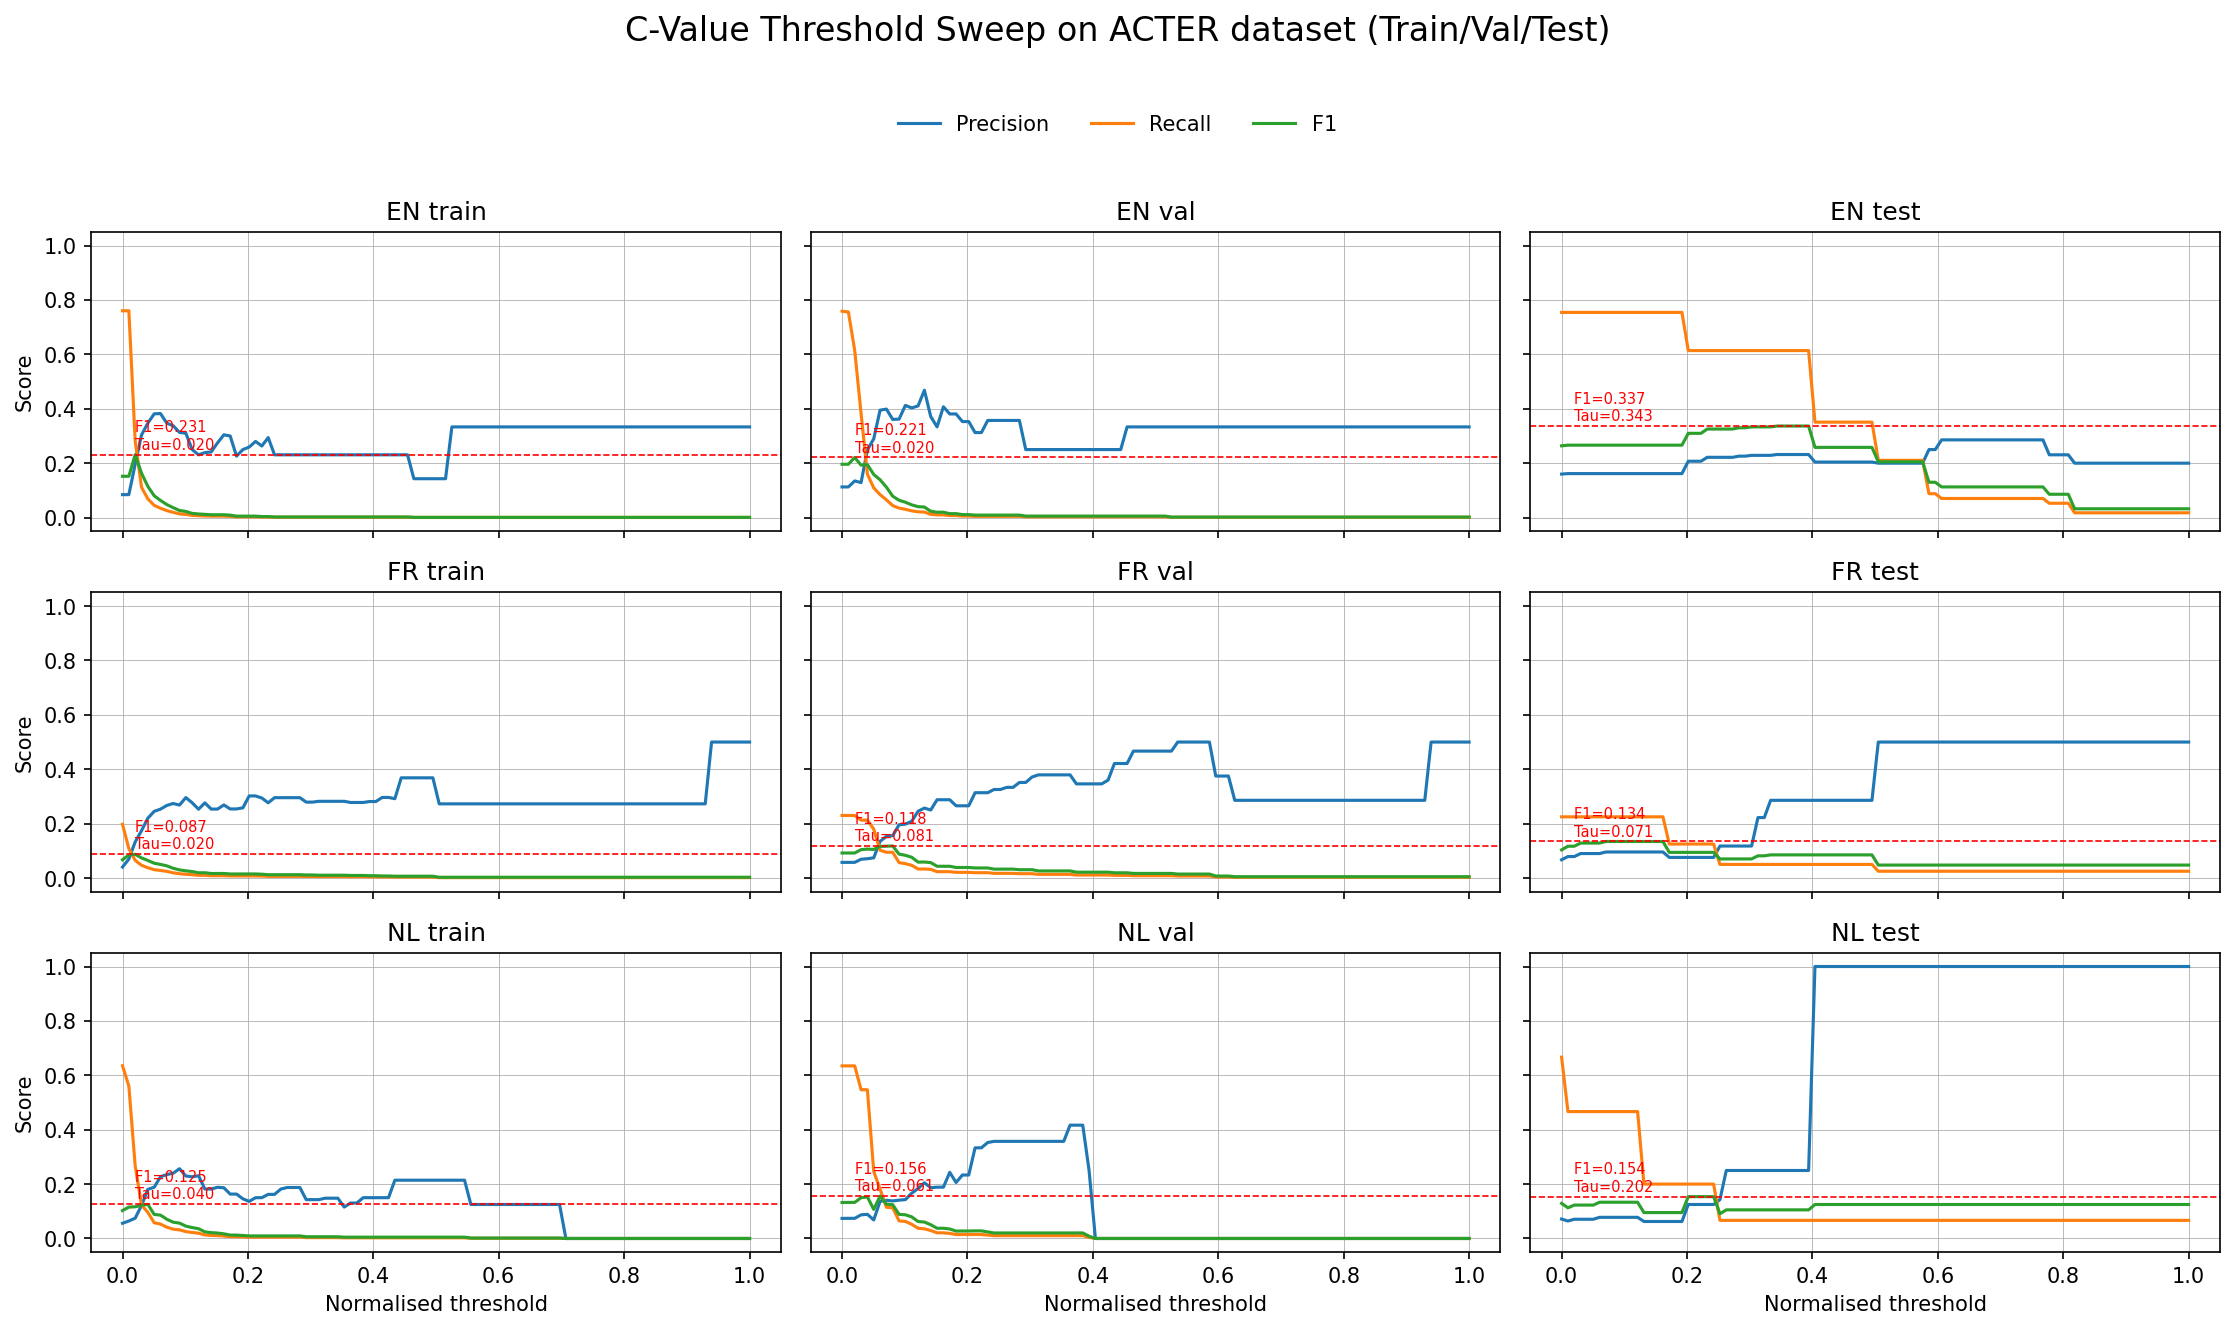

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from extractomat.tester import TermEvaluator

languages = list(c_value_results.keys())
splits    = list(next(iter(c_value_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, split in enumerate(splits):
        ax   = axes[r, c]
        data = c_value_results[lang][split]
        if not data:
            ax.axis("off"); continue

        gt_csv = (Path(language_output_dirs[lang][split])
                  .with_suffix("").joinpath("gt_labels.csv"))
        ev = TermEvaluator(gt_csv,
                           data["term_scores"],
                           data["term_occ"],
                           method="cvalue",
                           language=lang)

        scores   = np.fromiter(data["term_scores"].values(), float)
        lo, hi   = scores.min(), scores.max()
        abs_thr  = np.linspace(lo - 1e-9, hi, 100)
        norm_thr = (abs_thr - lo) / (hi - lo)

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        for i, t in enumerate(abs_thr):
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(t)
            except ZeroDivisionError:
                pass

        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)
        ax.axhline(F[best], color="red", ls="--", lw=.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f}", color="red", fontsize=7)

        if r == len(languages) - 1: ax.set_xlabel("Normalised threshold")
        if c == 0:                   ax.set_ylabel("Score")
        ax.set_title(f"{lang.upper()} {split}")
        ax.grid(True, lw=.4)

        print(f"{lang.upper()} {split:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f}")
        if split == "val":
            records.append({
                "Language":                   lang,
                "TE Method":                  "C-Value",
                "Sentence Selection Method":  None,
                "Tau@Best F1":                norm_thr[best],
                "%Sentences@Best F1":         1.0,
                "Precision@Best F1":          P[best],
                "Recall@Best F1":             R[best],
                "Best F1":                    F[best],
                "Score":                      F[best]
            })

fig.suptitle("C-Value Threshold Sweep on ACTER dataset (Train/Val/Test)", fontsize=16)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 0.92),
            ncol=3,
            frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
reranker = SentenceSimilarityCalculator(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    device=device
)

rerank_results = {lang: {} for lang in c_value_results}

for language, splits in c_value_results.items():
    nlp = spacy.load(language_nlp_models[language], disable=["ner"])
    nlp.max_length = 1500000

    for subset, cv_data in splits.items():
        subset_tsv = Path(language_output_dirs[language][subset])
        doc = nlp(Path(os.path.join(subset_tsv.with_suffix(''), "text.txt")).read_text().lower())

        reranked = reranker.rerank_terms_in_doc(
            doc,
            cv_data["term_occ"],
            context_len=3,
            pooling="max"
        )
        rerank_results[language][subset] = reranked

        print(f"[Rerank] {language} {subset}: {len(reranked):,} terms")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[Rerank] en train: 21,446 terms
[Rerank] en val: 6,720 terms
[Rerank] en test: 251 terms
[Rerank] fr train: 8,875 terms
[Rerank] fr val: 2,835 terms
[Rerank] fr test: 126 terms
[Rerank] nl train: 12,148 terms
[Rerank] nl val: 3,673 terms
[Rerank] nl test: 132 terms


[Rerank] EN train:  P=0.136  R=0.396  F1=0.202
[Rerank] EN val  :  P=0.155  R=0.484  F1=0.235
[Rerank] EN test :  P=0.208  R=0.702  F1=0.321
[Rerank] FR train:  P=0.055  R=0.099  F1=0.070
[Rerank] FR val  :  P=0.093  R=0.100  F1=0.096
[Rerank] FR test :  P=0.069  R=0.225  F1=0.106
[Rerank] NL train:  P=0.077  R=0.215  F1=0.113
[Rerank] NL val  :  P=0.090  R=0.305  F1=0.139
[Rerank] NL test :  P=0.074  R=0.600  F1=0.131


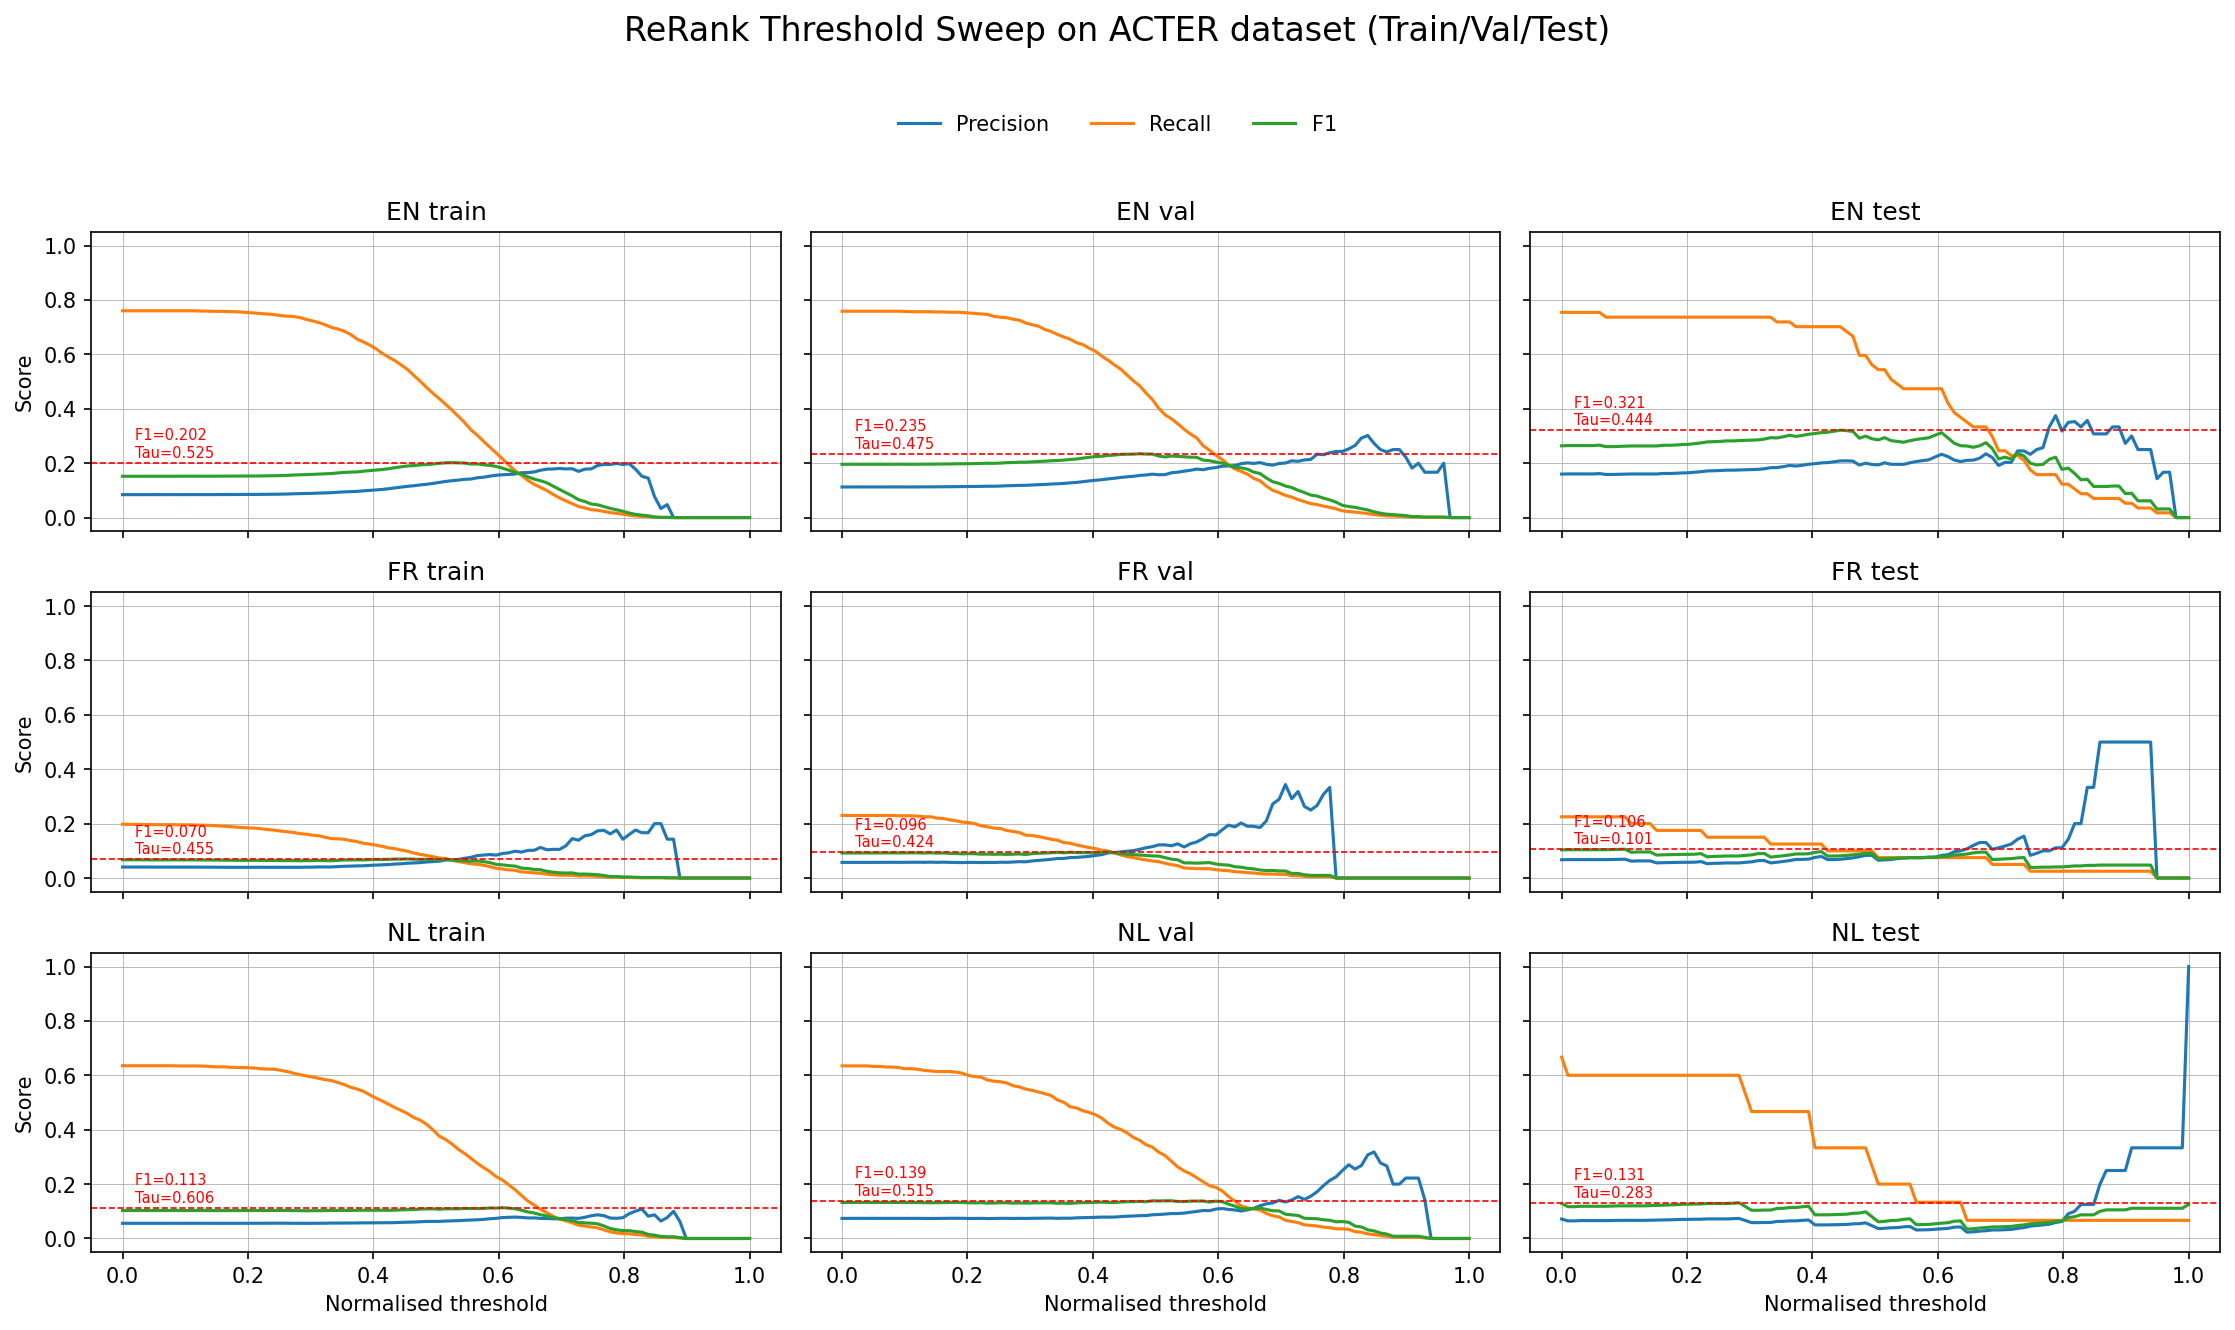

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from extractomat.tester import TermEvaluator

# assume rerank_results has the same structure as c_value_results:
#   rerank_results[lang][split] → dict(term → score)
# and term_occ still lives in c_value_results for each lang/split

languages = list(rerank_results.keys())
splits    = list(next(iter(rerank_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, split in enumerate(splits):
        ax    = axes[r, c]
        scores = rerank_results[lang][split]
        occ    = c_value_results[lang][split]["term_occ"]

        if not scores or not occ:
            ax.axis("off")
            continue

        gt_csv = (Path(language_output_dirs[lang][split])
                  .with_suffix("").joinpath("gt_labels.csv"))
        ev = TermEvaluator(gt_csv,
                           scores,
                           occ,
                           method="rerank",    # or still "cvalue" if metrics are the same
                           language=lang)

        arr = np.fromiter(scores.values(), float)
        lo, hi   = arr.min(), arr.max()
        abs_thr  = np.linspace(lo - 1e-9, hi, 100)
        norm_thr = (abs_thr - lo) / (hi - lo)

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        for i, t in enumerate(abs_thr):
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(t)
            except ZeroDivisionError:
                pass

        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)
        ax.axhline(F[best], color="red", ls="--", lw=.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f}", color="red", fontsize=7)

        if r == len(languages) - 1:
            ax.set_xlabel("Normalised threshold")
        if c == 0:
            ax.set_ylabel("Score")

        ax.set_title(f"{lang.upper()} {split}")
        ax.grid(True, lw=.4)

        print(f"[Rerank] {lang.upper()} {split:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f}")

        if split == "val":
            records.append({
                "Language":                   lang,
                "TE Method":                  "ReRank",
                "Sentence Selection Method":  None,
                "Tau@Best F1":                norm_thr[best],
                "%Sentences@Best F1":         1.0,
                "Precision@Best F1":          P[best],
                "Recall@Best F1":             R[best],
                "Best F1":                    F[best],
                "Score":                      F[best]
            })

fig.suptitle("ReRank Threshold Sweep on ACTER dataset (Train/Val/Test)", fontsize=16)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 0.92),
            ncol=3,
            frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [24]:
def read_iob_file(file_path: Path) -> list[list[str]]:
    sentences: List[List[str]] = []
    current: List[str] = []

    with file_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if current:
                    sentences.append(current)
                    current = []
                continue
            token = line.split("\t", 1)[0]
            current.append(token)

    if current:
        sentences.append(current)

    return sentences


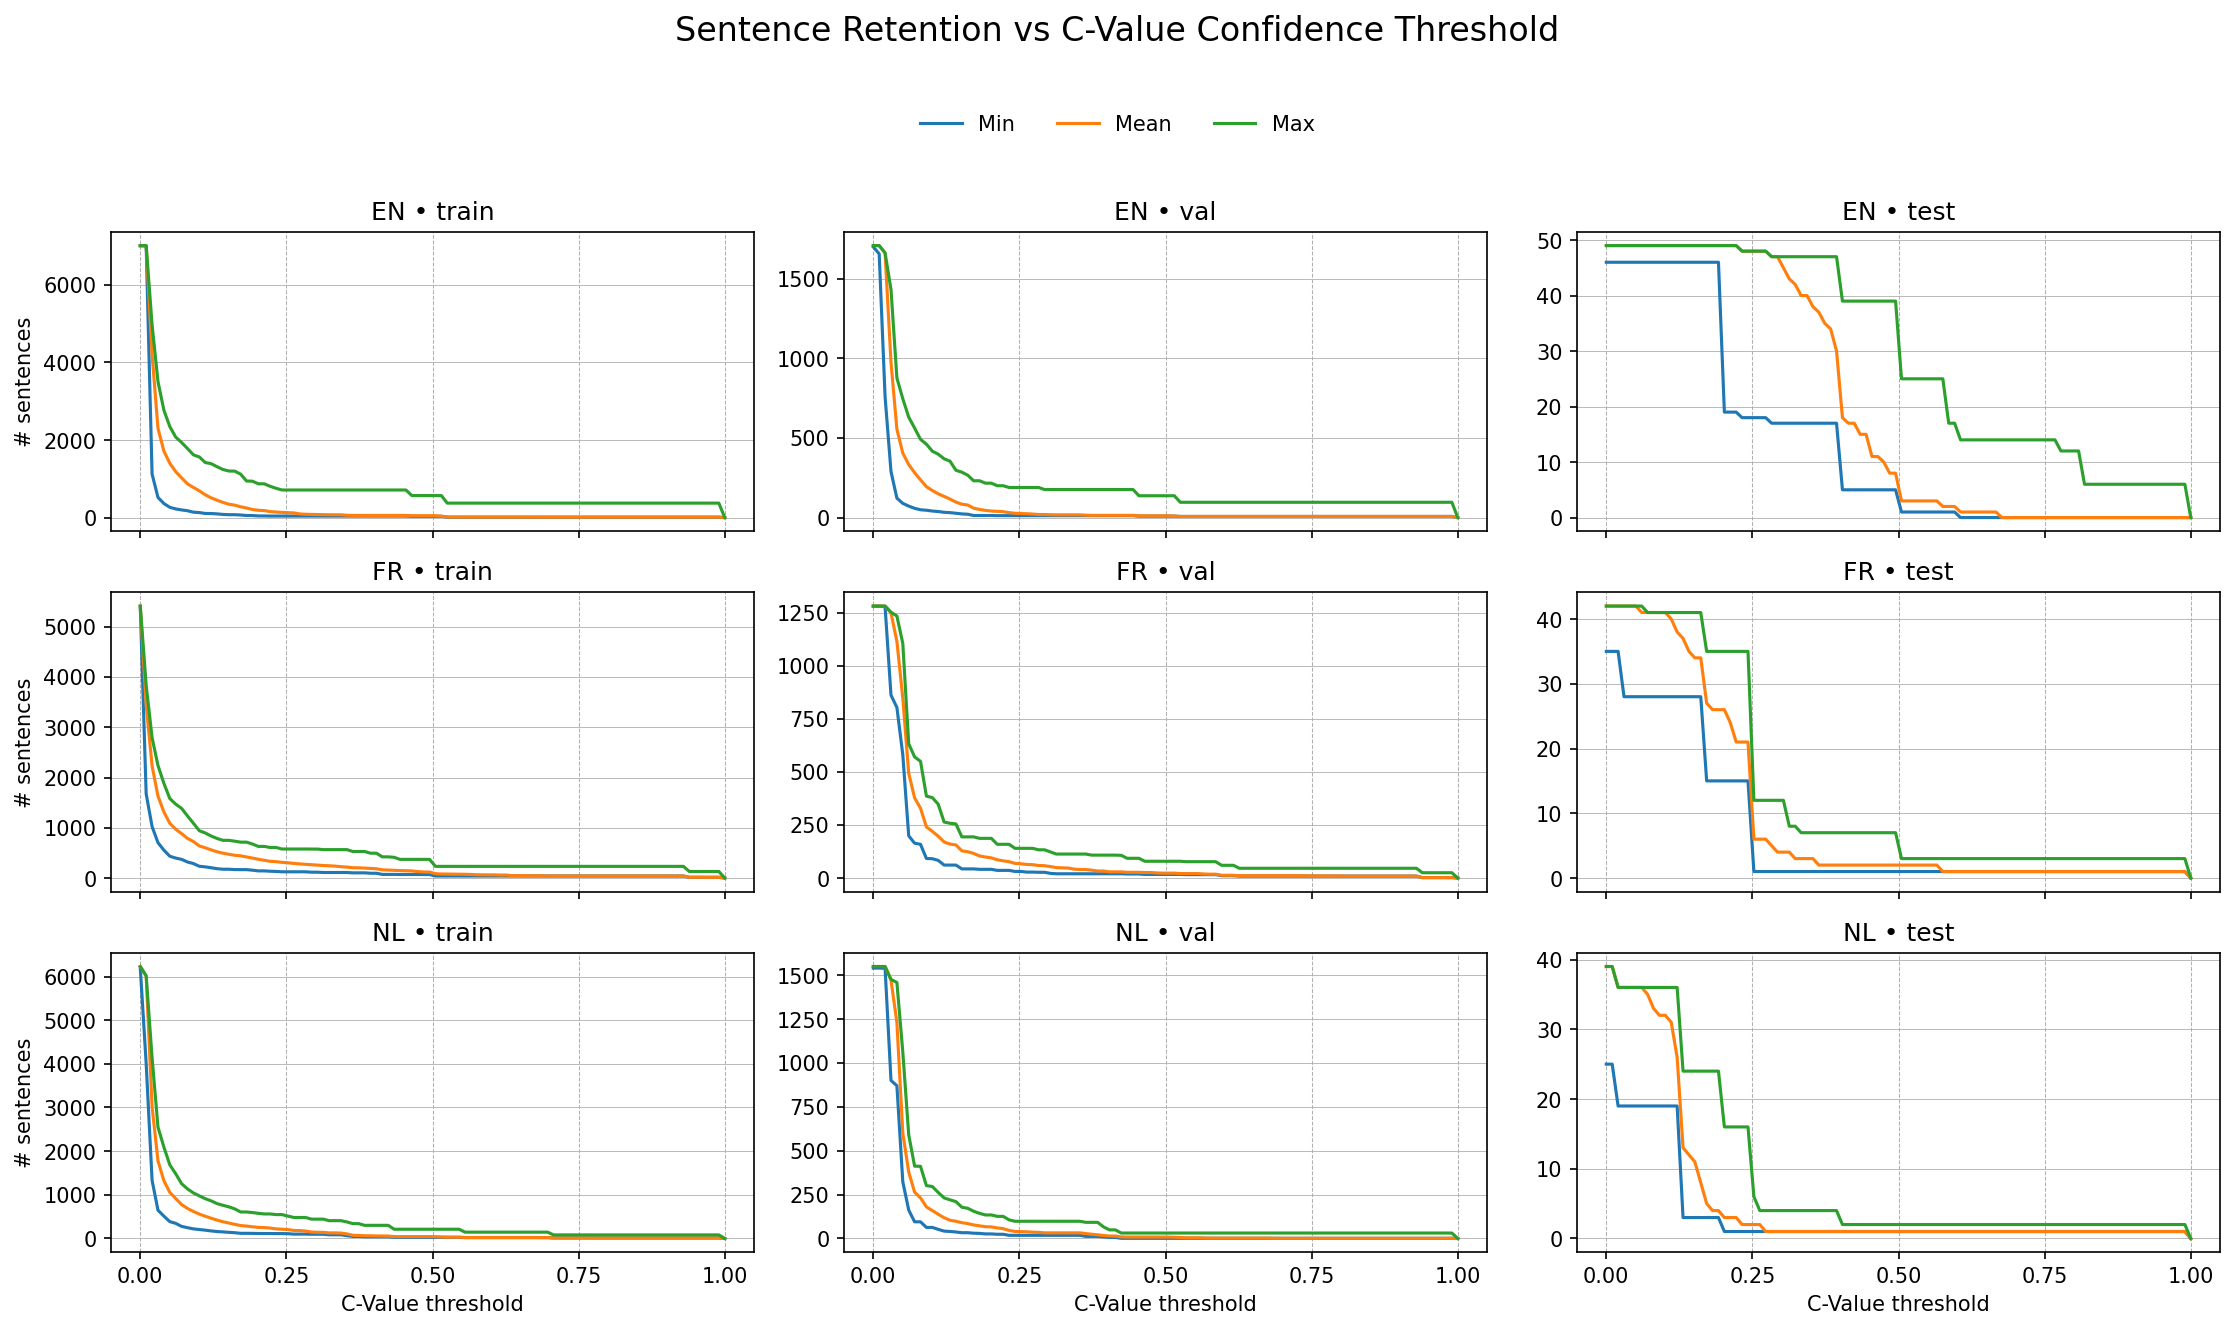

In [26]:
import bisect
from pathlib import Path
from collections import defaultdict
from extractomat.tester import TermEvaluator

# … your existing setup …
languages = list(rerank_results.keys())
splits    = list(next(iter(rerank_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=False)

for i, lang in enumerate(languages):
    for j, split in enumerate(splits):
        ax       = axes[i, j]
        c_scores = c_value_results[lang][split]["term_scores"]
        term_occ = c_value_results[lang][split]["term_occ"]

        # --- NEW: load IOB sentences and build sentence offsets ---
        tsv = Path(language_output_dirs[lang][split])
        sents = read_iob_file(tsv)            # list of list-of-tokens
        starts = []
        pos = 0
        for s in sents:
            starts.append(pos)
            pos += len(s)
        if not c_scores or not term_occ:
            ax.axis("off")
            continue

        # bucket rerank scores by sentence index via bisect on 'starts'
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            score = c_scores.get(term)
            if score is None:
                continue
            for sp in spans:
                # find which sentence this span.start belongs to
                sent_idx = bisect.bisect_right(starts, sp.start) - 1
                bucket_r[sent_idx].append(score)

        # now compute per-sentence stats only over those with at least one term
        mins, means, maxs = [], [], []
        for scores in bucket_r.values():
            mins.append(min(scores))
            means.append(np.mean(scores))
            maxs.append(max(scores))
        mins  = np.array(mins)
        means = np.array(means)
        maxs  = np.array(maxs)

        # threshold range
        thr = np.linspace(mins.min(), maxs.max(), 100)
        norm_thr = (thr - mins.min()) / (maxs.max() - mins.min())

        # count sentences above each threshold
        cnt_min  = [(mins  > t).sum() for t in thr]
        cnt_mean = [(means > t).sum() for t in thr]
        cnt_max  = [(maxs  > t).sum() for t in thr]

        # plot curves
        ax.plot(norm_thr, cnt_min,  label="Min")
        ax.plot(norm_thr, cnt_mean, label="Mean")
        ax.plot(norm_thr, cnt_max,  label="Max")

        # calculate 5% padding
        x0, x1 = norm_thr.min(), norm_thr.max()
        y0, y1 = 0, max(cnt_min + cnt_mean + cnt_max)
        x_pad  = 0.05 * (x1 - x0)
        y_pad  = 0.05 * (y1 - y0)

        # apply padding
        ax.set_xlim(x0 - x_pad, x1 + x_pad)
        ax.set_ylim(y0 - y_pad, y1 + y_pad)

        # set ticks and grids
        ax.set_xticks(np.linspace(x0, x1, 5))
        ax.grid(axis="x", linestyle="--", linewidth=0.5)
        ax.grid(axis="y", linewidth=0.4)

        # labels and titles
        if i == len(languages) - 1:
            ax.set_xlabel("C-Value threshold")
        if j == 0:
            ax.set_ylabel("# sentences")
        ax.set_title(f"{lang.upper()} • {split}")

# overall title and legend
fig.suptitle("Sentence Retention vs С-Value Confidence Threshold", fontsize=16)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 0.92),
            ncol=3,
            frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


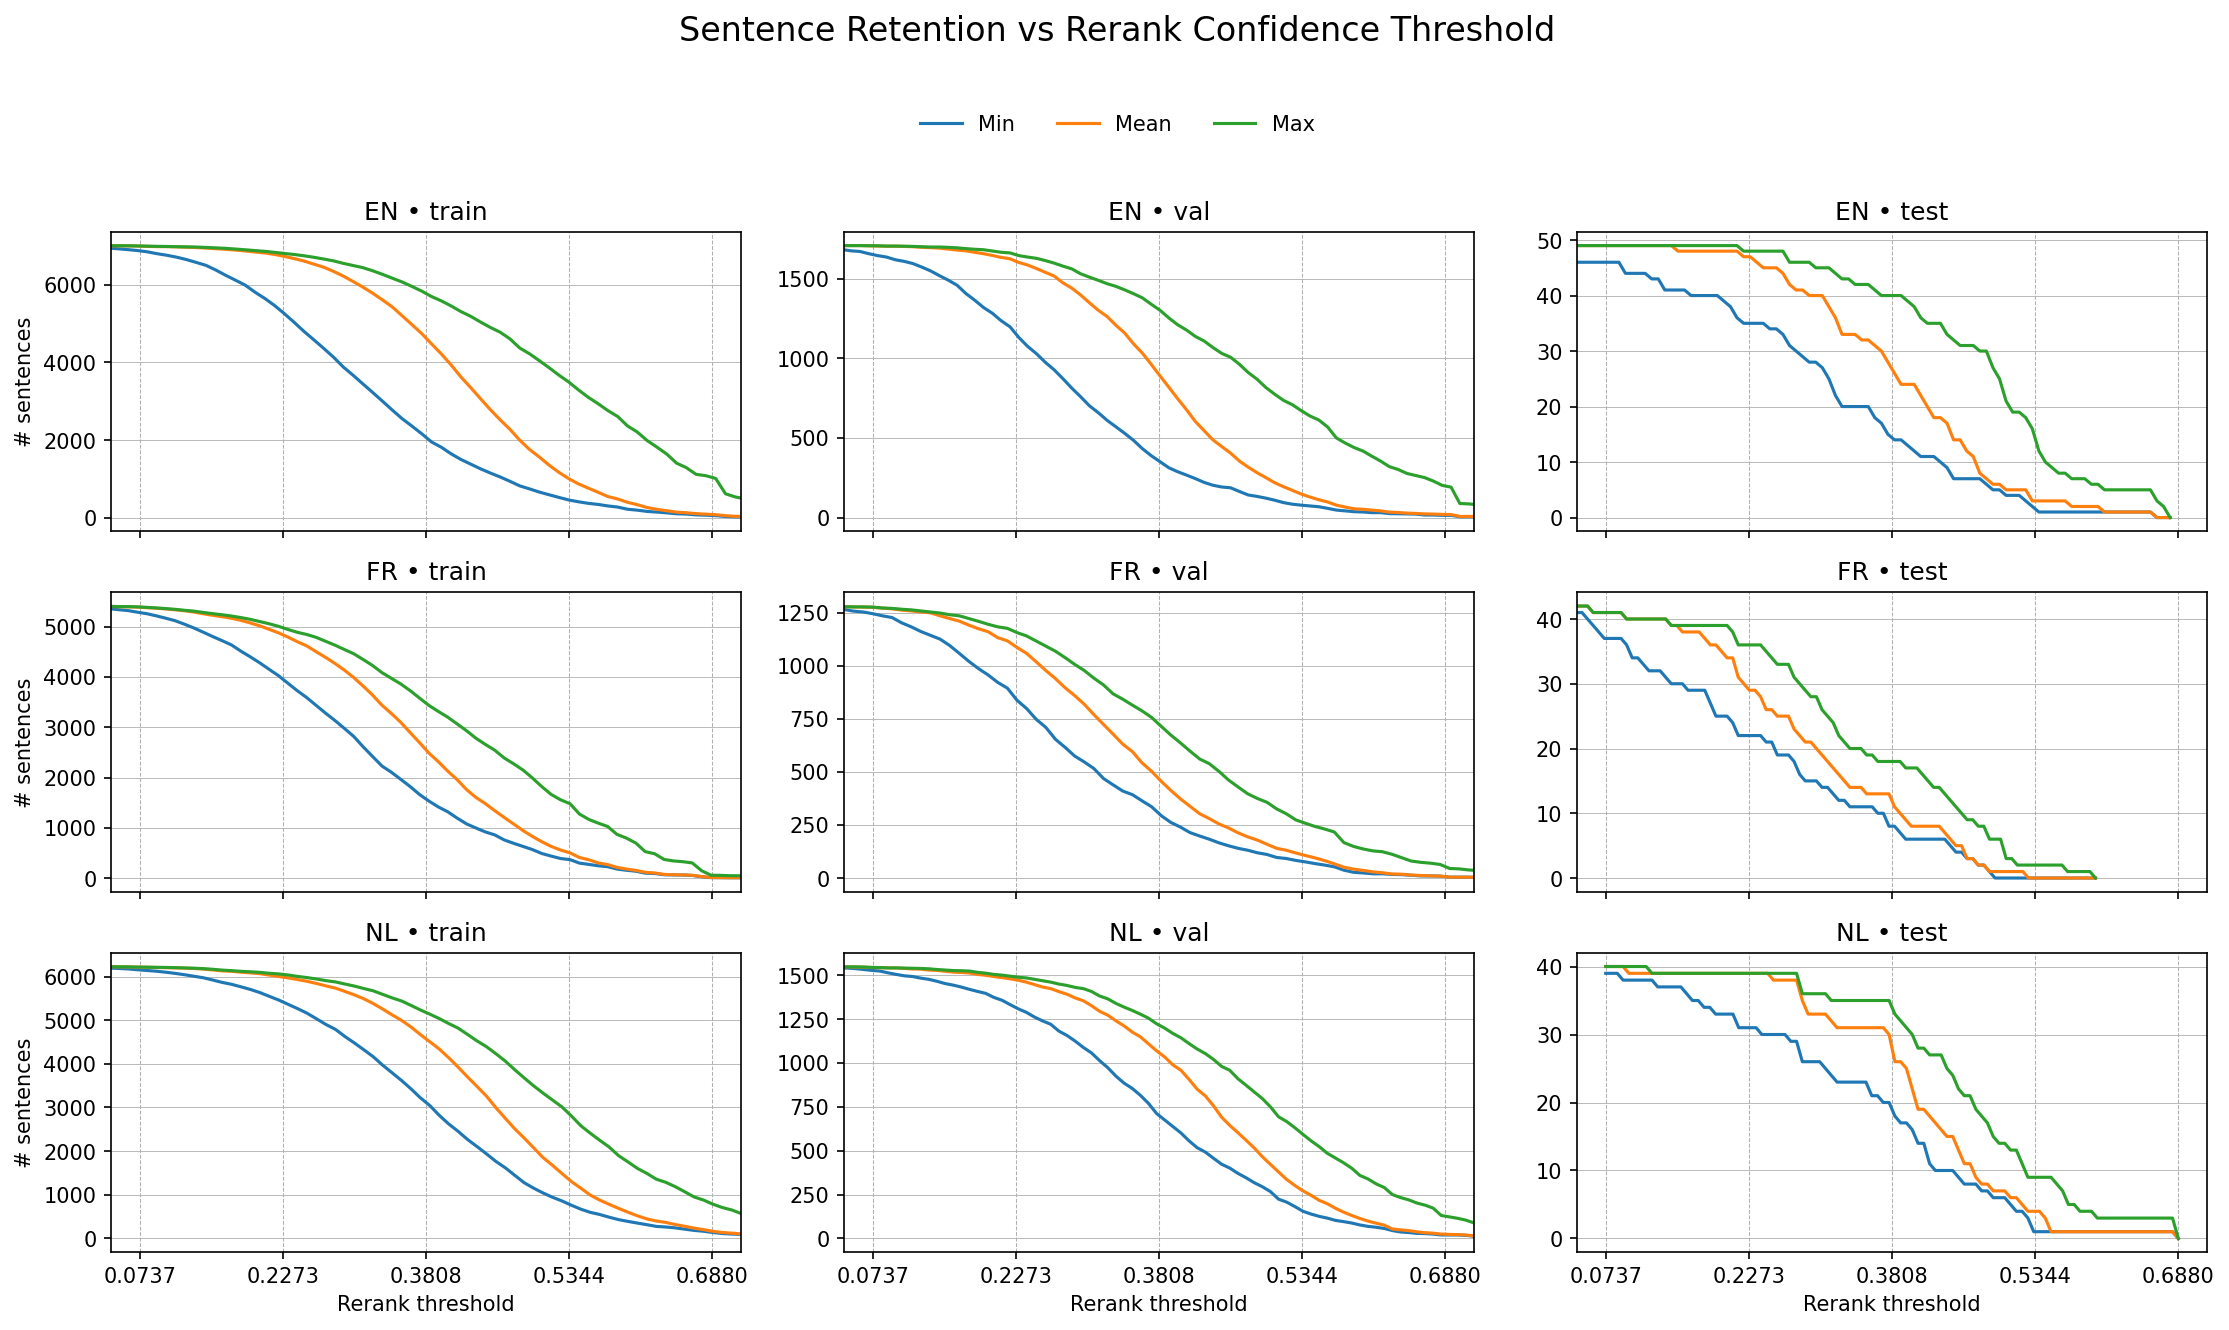

In [28]:
import bisect
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from extractomat.tester import TermEvaluator

languages = list(rerank_results.keys())
splits    = list(next(iter(rerank_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=False)

for i, lang in enumerate(languages):
    for j, split in enumerate(splits):
        ax       = axes[i, j]
        r_scores = rerank_results[lang][split]
        term_occ = c_value_results[lang][split]["term_occ"]

        # load IOB sentences and build sentence offsets
        tsv    = Path(language_output_dirs[lang][split])
        sents  = read_iob_file(tsv)  # List[List[str]]
        starts = []
        pos = 0
        for sent in sents:
            starts.append(pos)
            pos += len(sent)

        if not r_scores or not term_occ:
            ax.axis("off")
            continue

        # bucket rerank scores by sentence index
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            score = r_scores.get(term)
            if score is None:
                continue
            for sp in spans:
                sent_idx = bisect.bisect_right(starts, sp.start) - 1
                if sent_idx >= 0:
                    bucket_r[sent_idx].append(score)

        # compute per-sentence stats
        mins, means, maxs = [], [], []
        for scores in bucket_r.values():
            mins.append(min(scores))
            means.append(np.mean(scores))
            maxs.append(max(scores))
        mins  = np.array(mins)
        means = np.array(means)
        maxs  = np.array(maxs)

        # threshold range
        thr = np.linspace(mins.min(), maxs.max(), 100)

        # count sentences above each threshold
        cnt_min  = [(mins  > t).sum() for t in thr]
        cnt_mean = [(means > t).sum() for t in thr]
        cnt_max  = [(maxs  > t).sum() for t in thr]

        # plot curves
        ax.plot(thr, cnt_min,  label="Min")
        ax.plot(thr, cnt_mean, label="Mean")
        ax.plot(thr, cnt_max,  label="Max")

        # padding and grid
        x0, x1 = thr.min(), thr.max()
        y0, y1 = 0, max(cnt_min + cnt_mean + cnt_max)
        x_pad  = 0.05 * (x1 - x0)
        y_pad  = 0.05 * (y1 - y0)
        ax.set_xlim(x0 - x_pad, x1 + x_pad)
        ax.set_ylim(y0 - y_pad, y1 + y_pad)
        ax.set_xticks(np.linspace(x0, x1, 5))
        ax.grid(axis="x", linestyle="--", linewidth=0.5)
        ax.grid(axis="y", linewidth=0.4)

        # labels and titles
        if i == len(languages) - 1:
            ax.set_xlabel("Rerank threshold")
        if j == 0:
            ax.set_ylabel("# sentences")
        ax.set_title(f"{lang.upper()} • {split}")

# overall title and legend
fig.suptitle("Sentence Retention vs Rerank Confidence Threshold", fontsize=16)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           bbox_to_anchor=(0.5, 0.92),
           ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


[C-Value] EN min  :  P=0.117  R=0.726  F1=0.201 % Sentences Retained=43.84% Tau=0.091
[C-Value] EN mean :  P=0.141  R=0.477  F1=0.218 % Sentences Retained=100.00% Tau=0.020
[C-Value] EN max  :  P=0.142  R=0.481  F1=0.219 % Sentences Retained=100.00% Tau=0.020
[C-Value] FR min  :  P=0.058  R=0.230  F1=0.092 % Sentences Retained=60.78% Tau=0.010
[C-Value] FR mean :  P=0.069  R=0.212  F1=0.104 % Sentences Retained=99.75% Tau=0.071
[C-Value] FR max  :  P=0.069  R=0.202  F1=0.103 % Sentences Retained=99.75% Tau=0.121
[C-Value] NL min  :  P=0.121  R=0.186  F1=0.146 % Sentences Retained=64.05% Tau=0.040
[C-Value] NL mean :  P=0.091  R=0.292  F1=0.139 % Sentences Retained=100.00% Tau=0.030
[C-Value] NL max  :  P=0.076  R=0.547  F1=0.134 % Sentences Retained=100.00% Tau=0.010


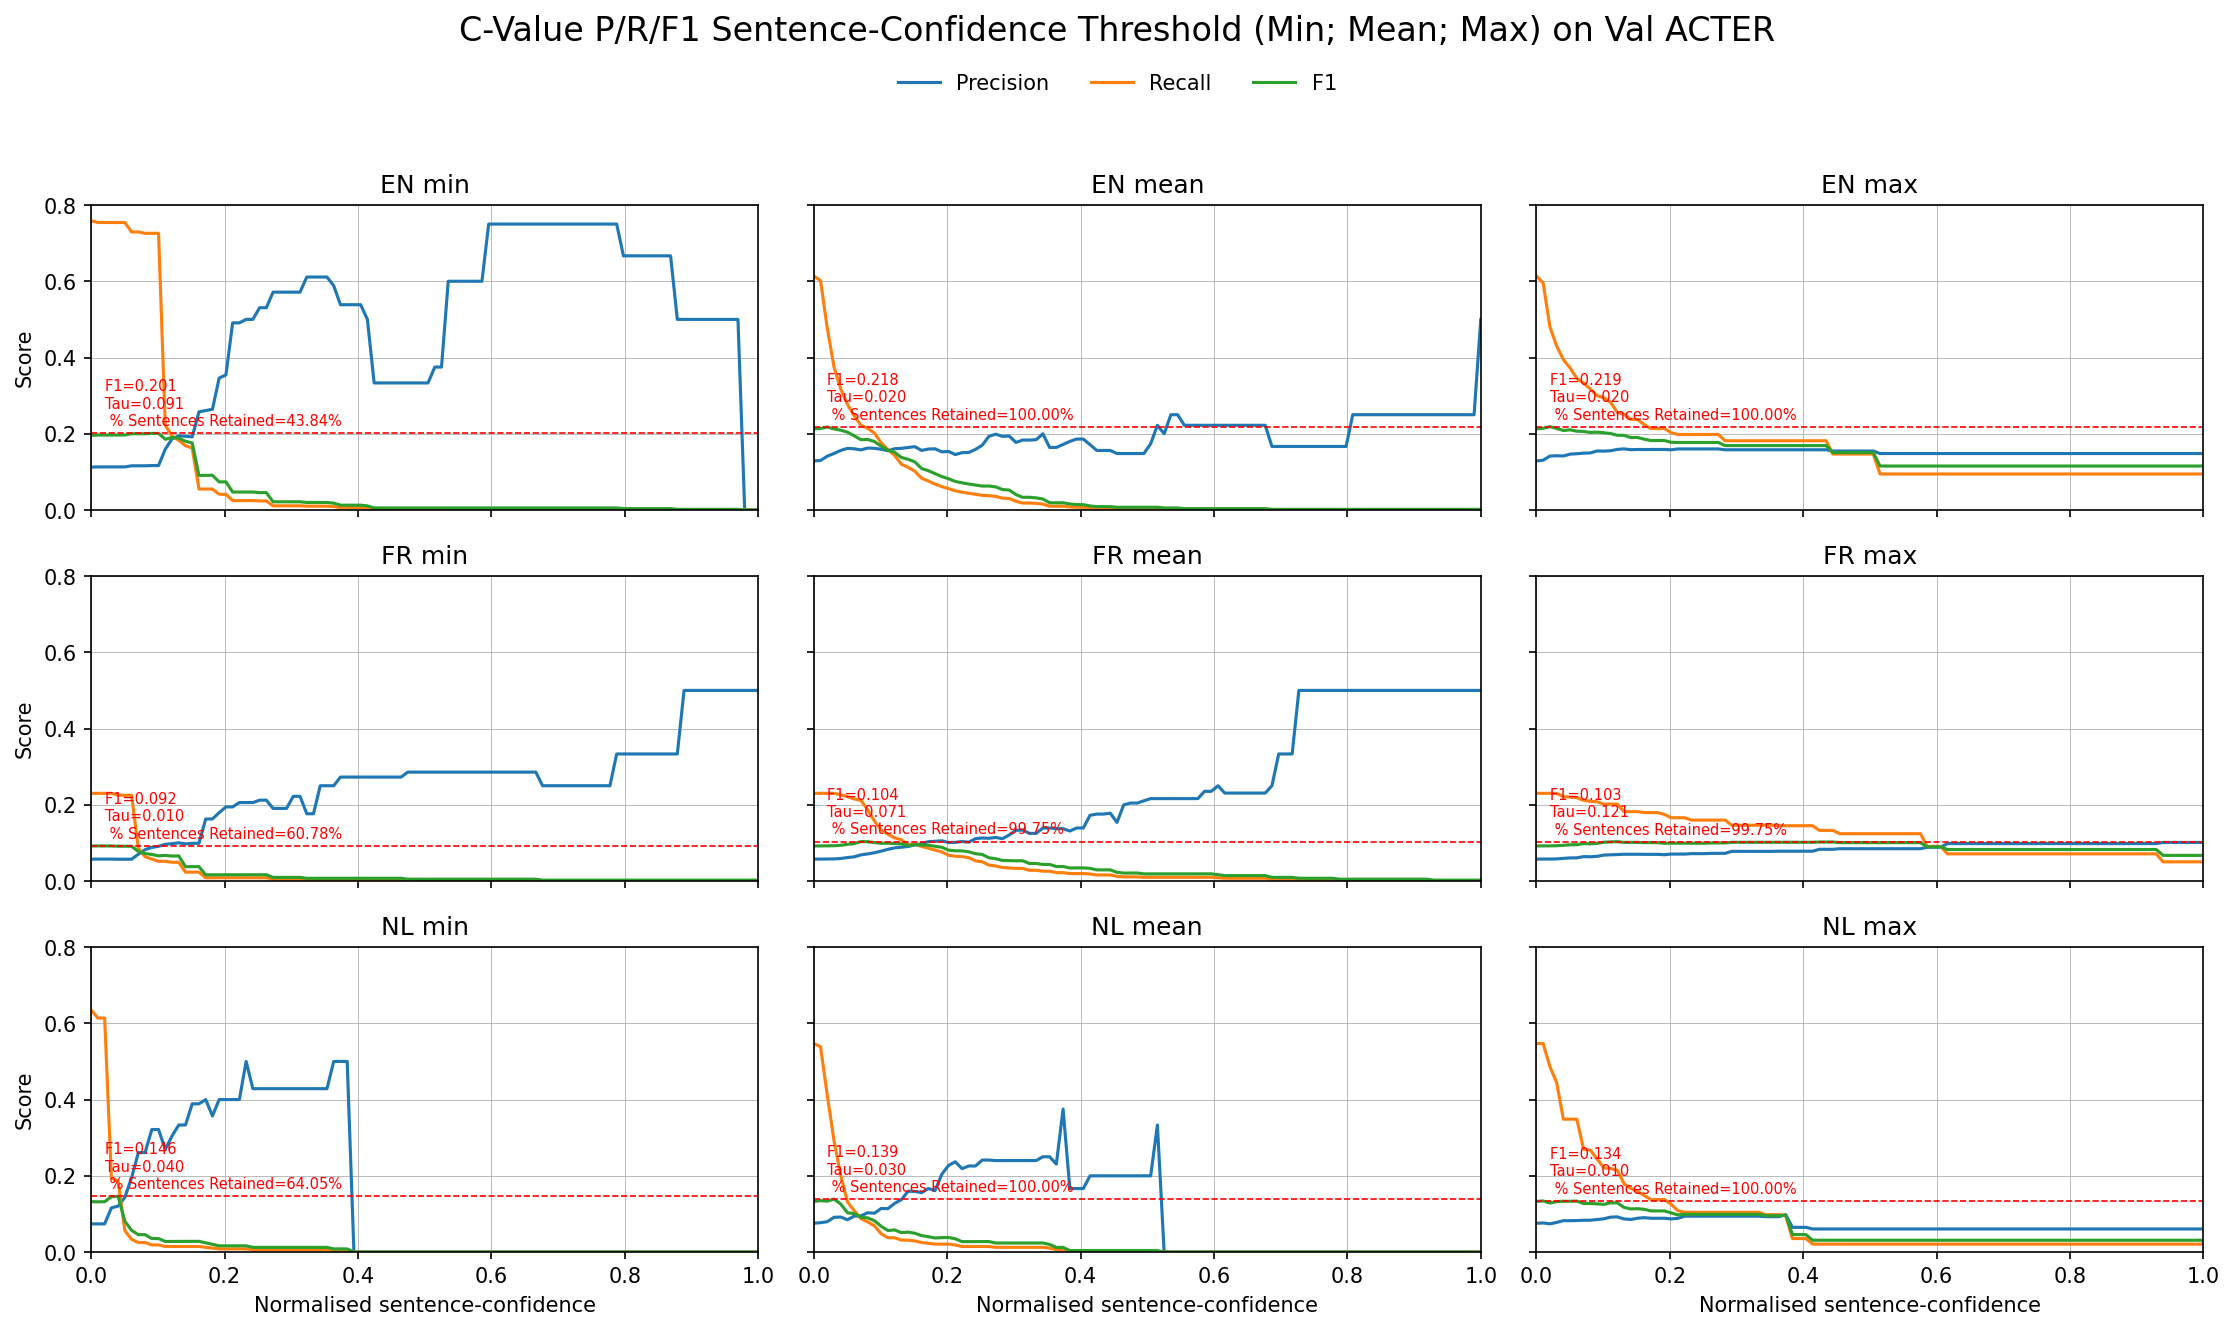

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from extractomat.tester import TermEvaluator

languages = list(rerank_results.keys())
sentence_selection_methods = ["min", "mean", "max"]

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, method in enumerate(sentence_selection_methods):
        split = "val"

        ax      = axes[r, c]
        scores  = c_value_results[lang][split]["term_scores"]
        term_occ = c_value_results[lang][split]["term_occ"]

        if not scores or not term_occ:
            ax.axis("off"); continue

        # bucket rerank scores by sentence
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            sc = scores.get(term)
            if sc is None: continue
            for span in spans:
                bucket_r[span.sent].append(sc)

        sent_method = {s: min(vs) for s, vs in bucket_r.items()} if method == "min" else \
                      {s: np.mean(vs) for s, vs in bucket_r.items()} if method == "mean" else \
                      {s: max(vs) for s, vs in bucket_r.items()}

        vals     = np.array(list(sent_method.values()))

        # sweep thresholds over [min..max]
        abs_thr  = np.linspace(vals.min(), vals.max(), 100)
        norm_thr = (abs_thr - vals.min()) / (vals.max() - vals.min())

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        # precompute gold path and minimal term threshold
        gt_csv = Path(language_output_dirs[lang][split]) \
                   .with_suffix("").joinpath("gt_labels.csv")
        for i, t in enumerate(abs_thr):
            # 1) select sentences >= t
            keep_sents = {s for s, m in sent_method.items() if m >= t}

            # 2) prune term_occ to those sentences
            pruned_occ = {}
            for term, spans in term_occ.items():
                fsp = [sp for sp in spans if sp.sent in keep_sents]
                if fsp:
                    pruned_occ[term] = fsp

            pruned_scores = {term: scores[term] for term in pruned_occ}

            # 3) evaluate on pruned corpus (threshold=lowest so all terms in pruned_occ get scored)
            ev = TermEvaluator(gt_csv,
                               pruned_scores,
                               pruned_occ,
                               method="cvalue",
                               language=lang)
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(abs_thr[0] - 1e-9)
            except ZeroDivisionError:
                P[i] = R[i] = F[i] = 0.0

        # plot
        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)
        percentage_sentences_retained = len({s for s, m in sent_method.items() if m >= norm_thr[best]}) / len(sent_method)

        ax.set_ylim(0, 0.8)
        ax.set_xlim(0, 1)

        ax.axhline(F[best], color="red", ls="--", lw=0.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f} \n % Sentences Retained={percentage_sentences_retained*100:.2f}%", color="red", fontsize=7)

        if r == len(languages) - 1:
            ax.set_xlabel("Normalised sentence-confidence")
        if c == 0:
            ax.set_ylabel("Score")

        ax.set_title(f"{lang.upper()} {method}")
        ax.grid(True, lw=0.4)

        print(f"[C-Value] {lang.upper()} {method:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f} % Sentences Retained={percentage_sentences_retained*100:.2f}% Tau={norm_thr[best]:.3f}")
        records.append({
            "Language":                   lang,
            "TE Method":                  "C-Value",
            "Sentence Selection Method":  method,
            "Tau@Best F1":                norm_thr[best],
            "%Sentences@Best F1":         percentage_sentences_retained,
            "Precision@Best F1":          P[best],
            "Recall@Best F1":             R[best],
            "Best F1":                    F[best],
            "Score":                      F[best]
        })

# legend & title
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           bbox_to_anchor=(0.5,0.95),
           ncol=3, frameon=False)
fig.suptitle("C-Value P/R/F1 Sentence-Confidence Threshold (Min; Mean; Max) on Val ACTER", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

[Rerank] EN min  :  P=0.130  R=0.512  F1=0.207 % Sentences Retained=23.61% Tau=0.343
[Rerank] EN mean :  P=0.146  R=0.387  F1=0.212 % Sentences Retained=18.86% Tau=0.465
[Rerank] EN max  :  P=0.130  R=0.486  F1=0.206 % Sentences Retained=28.15% Tau=0.606
[Rerank] FR min  :  P=0.060  R=0.200  F1=0.093 % Sentences Retained=83.82% Tau=0.111
[Rerank] FR mean :  P=0.071  R=0.135  F1=0.093 % Sentences Retained=70.59% Tau=0.323
[Rerank] FR max  :  P=0.071  R=0.194  F1=0.103 % Sentences Retained=51.96% Tau=0.535
[Rerank] NL min  :  P=0.128  R=0.167  F1=0.145 % Sentences Retained=13.21% Tau=0.495
[Rerank] NL mean :  P=0.153  R=0.154  F1=0.154 % Sentences Retained=5.56% Tau=0.606
[Rerank] NL max  :  P=0.084  R=0.451  F1=0.141 % Sentences Retained=33.66% Tau=0.596


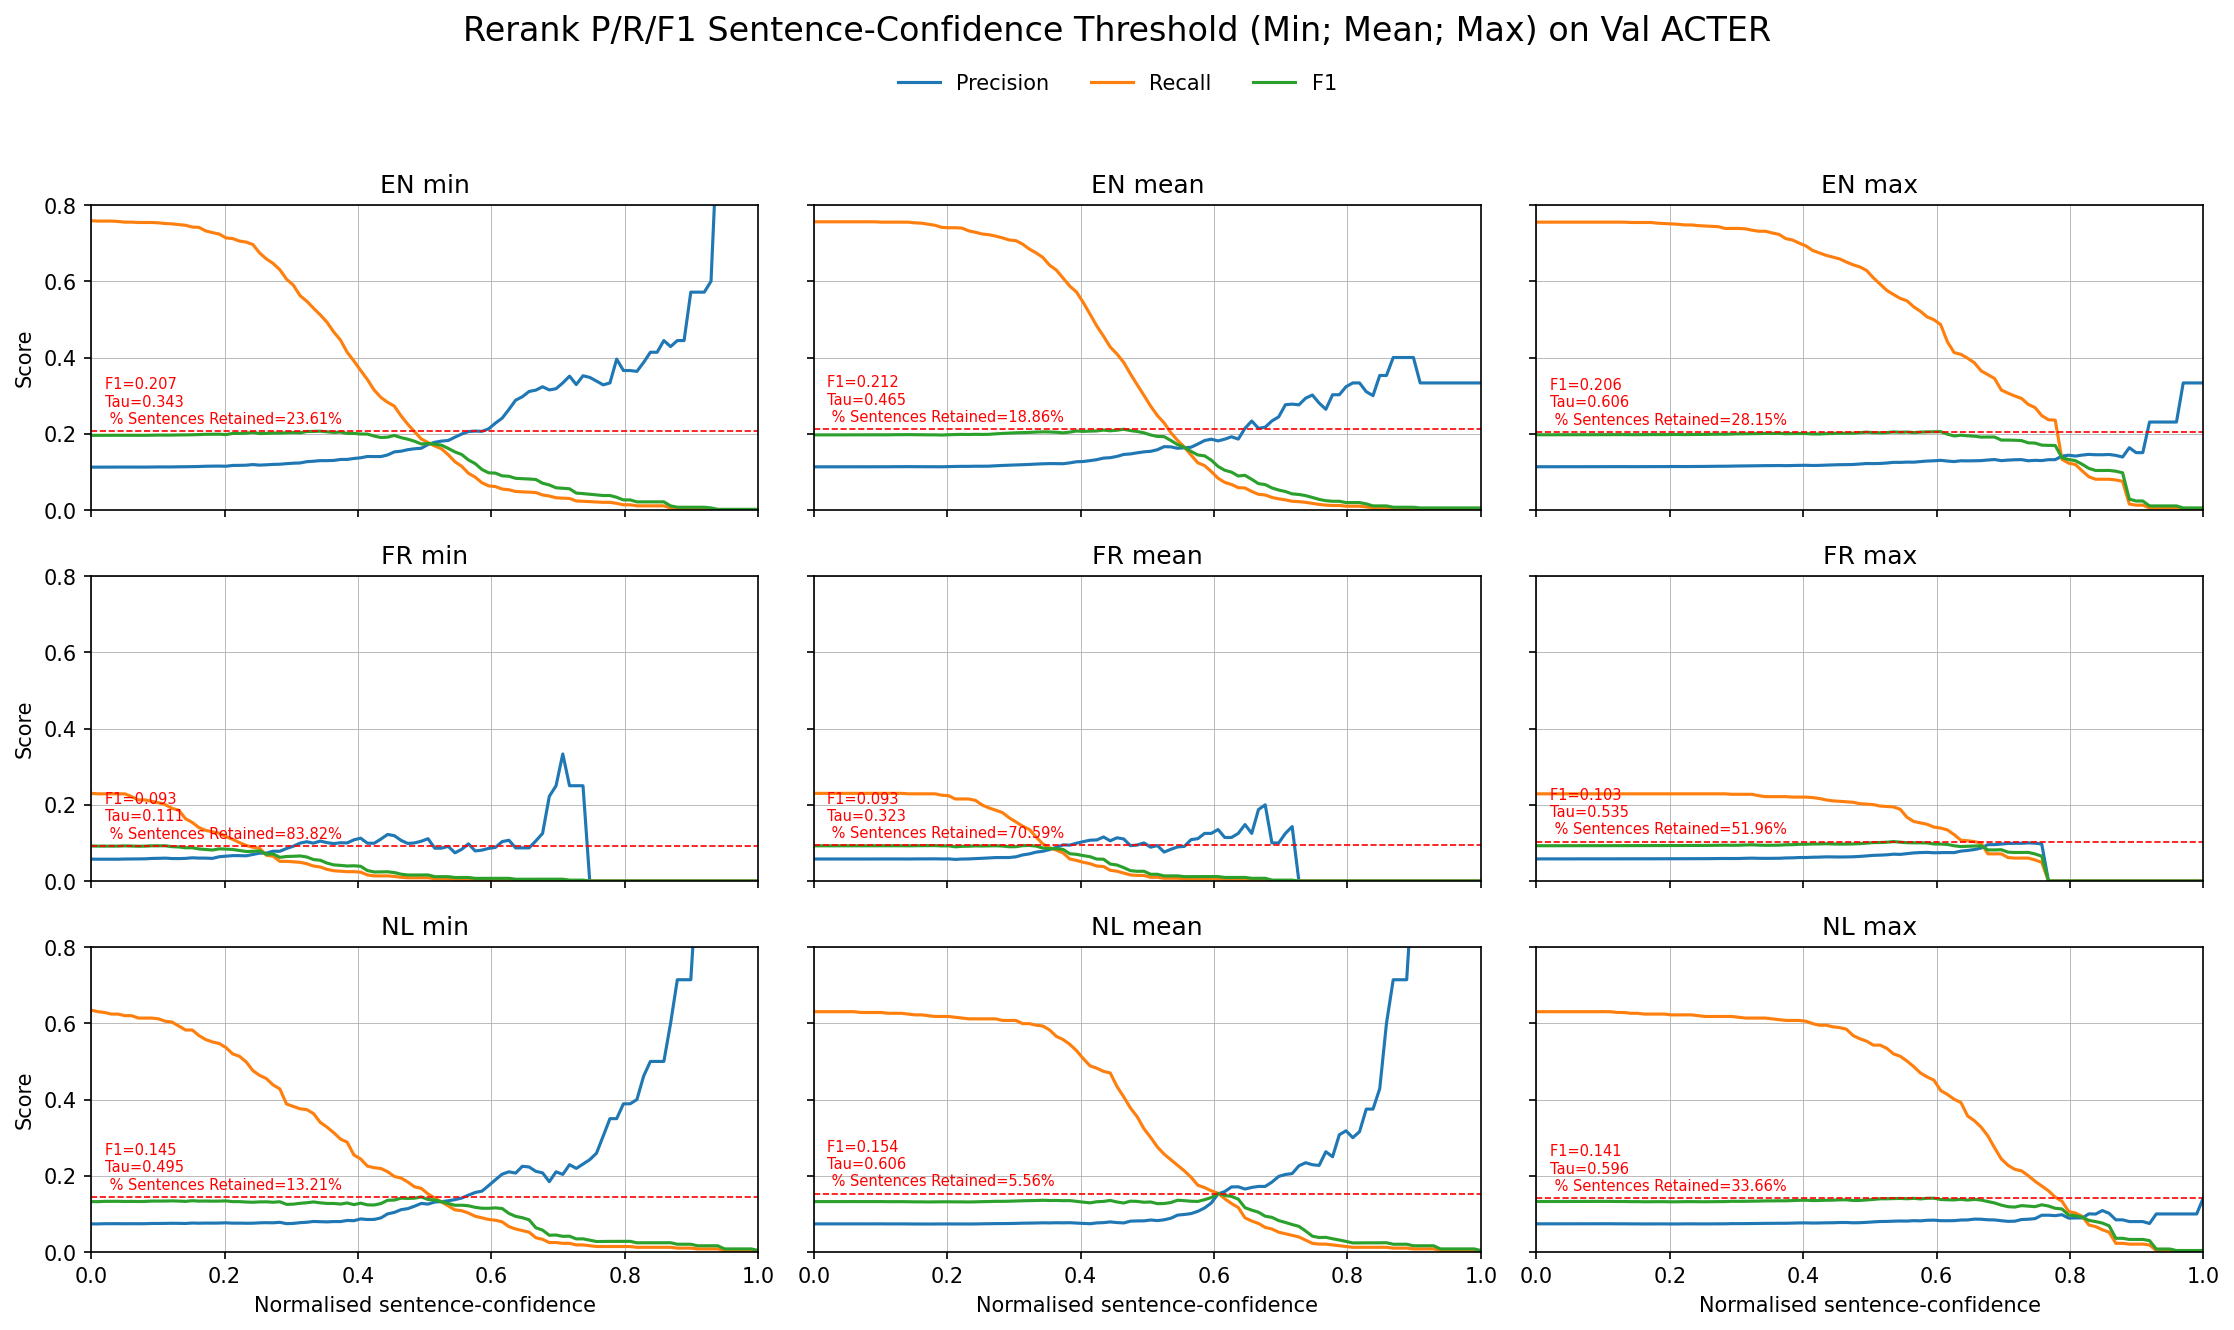

In [60]:
languages = list(rerank_results.keys())
sentence_selection_methods = ["min", "mean", "max"]

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, method in enumerate(sentence_selection_methods):
        split = "val"

        ax      = axes[r, c]
        scores  = rerank_results[lang][split]            # term → max‐sentence confidence
        term_occ = c_value_results[lang][split]["term_occ"]

        if not scores or not term_occ:
            ax.axis("off"); continue

        # bucket rerank scores by sentence
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            sc = scores.get(term)
            if sc is None: continue
            for span in spans:
                bucket_r[span.sent].append(sc)

        sent_method = {s: min(vs) for s, vs in bucket_r.items()} if method == "min" else \
                      {s: np.mean(vs) for s, vs in bucket_r.items()} if method == "mean" else \
                      {s: max(vs) for s, vs in bucket_r.items()}

        vals     = np.array(list(sent_method.values()))

        # sweep thresholds over [min..max]
        abs_thr  = np.linspace(vals.min(), vals.max(), 100)
        norm_thr = (abs_thr - vals.min()) / (vals.max() - vals.min())

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        # precompute gold path and minimal term threshold
        gt_csv = Path(language_output_dirs[lang][split]) \
                   .with_suffix("").joinpath("gt_labels.csv")
        for i, t in enumerate(abs_thr):
            # 1) select sentences >= t
            keep_sents = {s for s, m in sent_method.items() if m >= t}

            # 2) prune term_occ to those sentences
            pruned_occ = {}
            for term, spans in term_occ.items():
                fsp = [sp for sp in spans if sp.sent in keep_sents]
                if fsp:
                    pruned_occ[term] = fsp

            pruned_scores = {term: scores[term] for term in pruned_occ}

            # 3) evaluate on pruned corpus (threshold=lowest so all terms in pruned_occ get scored)
            ev = TermEvaluator(gt_csv,
                               pruned_scores,
                               pruned_occ,
                               method="rerank",
                               language=lang)
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(abs_thr[0] - 1e-9)
            except ZeroDivisionError:
                P[i] = R[i] = F[i] = 0.0

        # plot
        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)
        percentage_sentences_retained = len({s for s, m in sent_method.items() if m >= norm_thr[best]}) / len(sent_method)

        ax.set_ylim(0, 0.8)
        ax.set_xlim(0, 1)

        ax.axhline(F[best], color="red", ls="--", lw=0.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f} \n % Sentences Retained={percentage_sentences_retained*100:.2f}%", color="red", fontsize=7)

        if r == len(languages) - 1:
            ax.set_xlabel("Normalised sentence-confidence")
        if c == 0:
            ax.set_ylabel("Score")

        ax.set_title(f"{lang.upper()} {method}")
        ax.grid(True, lw=0.4)

        print(f"[Rerank] {lang.upper()} {method:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f} % Sentences Retained={percentage_sentences_retained*100:.2f}% Tau={norm_thr[best]:.3f}")
        records.append({
            "Language":                   lang,
            "TE Method":                  "ReRank",
            "Sentence Selection Method":  method,
            "Tau@Best F1":                norm_thr[best],
            "%Sentences@Best F1":         percentage_sentences_retained,
            "Precision@Best F1":          P[best],
            "Recall@Best F1":             R[best],
            "Best F1":                    F[best],
            "Score":                      F[best]
        })


# legend & title
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           bbox_to_anchor=(0.5,0.95),
           ncol=3, frameon=False)
fig.suptitle("Rerank P/R/F1 Sentence-Confidence Threshold (Min; Mean; Max) on Val ACTER", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [61]:
import pandas as pd

results_df = pd.DataFrame.from_records(records)
best_results_df = (
    results_df
    .loc[results_df.groupby("Language")["Best F1"].idxmax()]
    .reset_index(drop=True)
)

from IPython.display import display

display(
    results_df.style.format({
        "%Sentences@Best F1":    "{:.2%}",
        "Precision@Best F1":     "{:.2f}",
        "Recall@Best F1":        "{:.2f}",
        "Best F1":               "{:.2%}",
        "Score":                 "{:.2f}"
    })
)
display(
    best_results_df.style.format({
        "%Sentences@Best F1":    "{:.2%}",
        "Precision@Best F1":     "{:.2f}",
        "Recall@Best F1":        "{:.2f}",
        "Best F1":               "{:.2%}",
        "Score":                 "{:.2f}"
    })
)

results_df.to_csv("results.csv", index=False)
best_results_df.to_csv("best_results.csv", index=False)
language_best_te_method = {
    row["Language"][:2].lower(): {
        "te_method":                row["TE Method"],
        "sentence_selection_method": row["Sentence Selection Method"],
        "tau":                      float(row["Tau@Best F1"])
    }
    for _, row in best_results_df.iterrows()
}

import pprint
pprint.pprint(language_best_te_method)


,Language,TE Method,Sentence Selection Method,Tau@Best F1,%Sentences@Best F1,Precision@Best F1,Recall@Best F1,Best F1,Score
0,en,C-Value,None,0.020202,100.00%,0.13,0.61,22.09%,0.22
1,fr,C-Value,None,0.080808,100.00%,0.16,0.09,11.78%,0.12
2,nl,C-Value,None,0.060606,100.00%,0.14,0.18,15.59%,0.16
3,en,ReRank,None,0.474747,100.00%,0.15,0.48,23.48%,0.23
4,fr,ReRank,None,0.424242,100.00%,0.09,0.10,9.60%,0.10
5,nl,ReRank,None,0.515152,100.00%,0.09,0.30,13.87%,0.14
6,en,C-Value,min,0.090909,43.84%,0.12,0.73,20.09%,0.20
7,en,C-Value,mean,0.020202,100.00%,0.14,0.48,21.78%,0.22
8,en,C-Value,max,0.020202,100.00%,0.14,0.48,21.87%,0.22
9,fr,C-Value,min,0.010101,60.78%,0.06,0.23,9.21%,0.09


,Language,TE Method,Sentence Selection Method,Tau@Best F1,%Sentences@Best F1,Precision@Best F1,Recall@Best F1,Best F1,Score
0,en,ReRank,None,0.474747,100.00%,0.15,0.48,23.48%,0.23
1,fr,C-Value,None,0.080808,100.00%,0.16,0.09,11.78%,0.12
2,nl,C-Value,None,0.060606,100.00%,0.14,0.18,15.59%,0.16


{'en': {'sentence_selection_method': None,
        'tau': 0.47474747418676777,
        'te_method': 'ReRank'},
 'fr': {'sentence_selection_method': None,
        'tau': 0.08080808079029138,
        'te_method': 'C-Value'},
 'nl': {'sentence_selection_method': None,
        'tau': 0.06060606058773548,
        'te_method': 'C-Value'}}


In [62]:
import bisect, numpy as np, pandas as pd
from pathlib import Path
from collections import defaultdict


root_out = Path("/content/drive/MyDrive/ucu/ner/new_threshold_datasets")
stats = []

for lang, cfg in language_best_te_method.items():
    te_method, sent_sel, tau = cfg["te_method"], cfg["sentence_selection_method"], cfg["tau"]
    sel_tag = sent_sel or "none"

    for split in c_value_results[lang]:
        tsv = Path(language_output_dirs[lang][split])
        sents = read_iob_file(tsv)

        starts, pos = [], 0
        for s in sents:
            starts.append(pos)
            pos += len(s)

        term_occ = c_value_results[lang][split]["term_occ"]
        scores = c_value_results[lang][split]["term_scores"] if te_method == "cvalue" else rerank_results[lang][split]

        s2sp = defaultdict(list)
        for term, spans in term_occ.items():
            sc = scores.get(term, 0.0)
            for sp in spans:
                idx = bisect.bisect_right(starts, sp.start) - 1
                s2sp[idx].append((sp, sc))

        if sent_sel:
            agg = {"min": min, "mean": np.mean, "max": max}[sent_sel]
            sent_score = {i: agg([sc for _, sc in arr]) for i, arr in s2sp.items()}

        out_path = (root_out / lang / f"{te_method}_{sel_tag}_{tau:.3f}_{split}.tsv")
        out_path.parent.mkdir(parents=True, exist_ok=True)

        b_cnt = i_cnt = o_cnt = kept_cnt = 0
        with out_path.open("w", encoding="utf-8") as fout:
            for i, s in enumerate(sents):
                if sent_sel and sent_score.get(i, 0.0) < tau:
                    continue                                  # drop sentence
                triples = [(sp, sc) for sp, sc in s2sp.get(i, []) if sc >= tau]

                lab = ["O"] * len(s)
                for sp, _ in triples:
                    st = sp.start - starts[i]
                    en = sp.end   - starts[i]
                    if 0 <= st < en <= len(lab):
                        lab[st] = "B-TERM"
                        for k in range(st + 1, en):
                            lab[k] = "I-TERM"

                b_cnt += lab.count("B-TERM")
                i_cnt += lab.count("I-TERM")
                o_cnt += lab.count("O")
                kept_cnt += 1

                for tok, lbl in zip(s, lab):
                    fout.write(f"{tok}\t{lbl}\n")
                fout.write("\n")

        orig_cnt = len(sents)
        stats.append({
            "language": lang, "split": split,
            "method": te_method, "sentence_sel": sel_tag, "tau": tau,
            "#orig_sent": orig_cnt,
            "#saved_sent": kept_cnt,
            "%retained": round(100 * kept_cnt / orig_cnt, 2),
            "#entities": b_cnt + i_cnt,
            "#b": b_cnt, "#i": i_cnt, "#o": o_cnt,
        })
        print(f"{out_path}  orig={orig_cnt}  kept={kept_cnt} "
              f"({100*kept_cnt/orig_cnt:.1f}%)  B={b_cnt} I={i_cnt} O={o_cnt}")

df = pd.DataFrame(stats)
from IPython.display import display
display(df)


/content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/ReRank_none_0.475_train.tsv  orig=11343  kept=11343 (100.0%)  B=7312 I=12360 O=158098
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/ReRank_none_0.475_val.tsv  orig=2748  kept=2748 (100.0%)  B=1353 I=2354 O=39596
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/ReRank_none_0.475_test.tsv  orig=71  kept=71 (100.0%)  B=42 I=78 O=1088
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/C-Value_none_0.081_train.tsv  orig=9397  kept=9397 (100.0%)  B=10049 I=17895 O=164648
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/C-Value_none_0.081_val.tsv  orig=2277  kept=2277 (100.0%)  B=2464 I=4307 O=39316
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/C-Value_none_0.081_test.tsv  orig=59  kept=59 (100.0%)  B=84 I=146 O=1298
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/nl/C-Value_none_0.061_train.tsv  orig=9525  kept=9525 (100.0%)  B=11770 I=17813 O=145407
/content/drive/MyDrive/ucu/ner/new_t

,language,split,method,sentence_sel,tau,#orig_sent,#saved_sent,%retained,#entities,#b,#i,#o
0,en,train,ReRank,none,0.474747,11343,11343,100.0,19672,7312,12360,158098
1,en,val,ReRank,none,0.474747,2748,2748,100.0,3707,1353,2354,39596
2,en,test,ReRank,none,0.474747,71,71,100.0,120,42,78,1088
3,fr,train,C-Value,none,0.080808,9397,9397,100.0,27944,10049,17895,164648
4,fr,val,C-Value,none,0.080808,2277,2277,100.0,6771,2464,4307,39316
5,fr,test,C-Value,none,0.080808,59,59,100.0,230,84,146,1298
6,nl,train,C-Value,none,0.060606,9525,9525,100.0,29583,11770,17813,145407
7,nl,val,C-Value,none,0.060606,2308,2308,100.0,7362,2923,4439,35295
8,nl,test,C-Value,none,0.060606,60,60,100.0,234,90,144,1108
